In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as pylab
import numpy as np
%matplotlib inline

In [30]:
#Data Prepration
import re

In [31]:
sentences = """Mango is the national fruit of India which is loved by one and all. 
It is a very juicy, pulpy and luscious fruit. Ripe mangoes can either be consumed raw or 
in the form of salad, juice, jams, milkshake or pickles. 
Mango is a rich source of various vitamins and minerals."""

Clean Data

In [32]:
# remove special characters
sentences = re.sub('[^A-Za-z0-9]+', ' ', sentences)

# remove 1 letter words
sentences = re.sub(r'(?:^| )\w(?:$| )', ' ', sentences).strip()

# lower all characters
sentences = sentences.lower()

Vocabulary

In [33]:
words = sentences.split()
vocab = set(words)

In [35]:
vocab_size = len(vocab)
embed_dim = 10
context_size = 2

Dictionary

In [36]:
word_to_ix = {word: i for i, word in enumerate(vocab)}
ix_to_word = {i: word for i, word in enumerate(vocab)}

Data bags

In [71]:
# data - [(context), target]

data = []
for i in range(2, len(words) - 2):
    context = [words[i - 2], words[i - 1], words[i + 1], words[i + 2]]
    target = words[i]
    data.append((context, target))
print(data[:5])

[(['mango', 'is', 'national', 'fruit'], 'the'), (['is', 'the', 'fruit', 'of'], 'national'), (['the', 'national', 'of', 'india'], 'fruit'), (['national', 'fruit', 'india', 'which'], 'of'), (['fruit', 'of', 'which', 'is'], 'india')]


Embeddings

In [39]:
embeddings =  np.random.random_sample((vocab_size, embed_dim))

Linear Model

In [40]:
def linear(m, theta):
    w = theta
    return m.dot(w)

Log softmax + NLLloss = Cross Entropy

In [41]:
def log_softmax(x):
    e_x = np.exp(x - np.max(x))
    return np.log(e_x / e_x.sum())

In [42]:
def NLLLoss(logs, targets):
    out = logs[range(len(targets)), targets]
    return -out.sum()/len(out)

In [43]:
def log_softmax_crossentropy_with_logits(logits,target):

    out = np.zeros_like(logits)
    out[np.arange(len(logits)),target] = 1
    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)
    
    return (- out + softmax) / logits.shape[0]

Forward function

In [44]:
def forward(context_idxs, theta):
    m = embeddings[context_idxs].reshape(1, -1)
    n = linear(m, theta)
    o = log_softmax(n)
    
    return m, n, o

Backward function

In [45]:
def backward(preds, theta, target_idxs):
    m, n, o = preds
    
    dlog = log_softmax_crossentropy_with_logits(n, target_idxs)
    dw = m.T.dot(dlog)
    
    return dw

Optimize function

In [46]:
def optimize(theta, grad, lr=0.03):
    theta -= grad * lr
    return theta

Training 

In [47]:
#Genrate training data

theta = np.random.uniform(-1, 1, (2 * context_size * embed_dim, vocab_size))

In [48]:
epoch_losses = {}

for epoch in range(80):

    losses =  []

    for context, target in data:
        context_idxs = np.array([word_to_ix[w] for w in context])
        preds = forward(context_idxs, theta)

        target_idxs = np.array([word_to_ix[target]])
        loss = NLLLoss(preds[-1], target_idxs)

        losses.append(loss)

        grad = backward(preds, theta, target_idxs)
        theta = optimize(theta, grad, lr=0.03)
        
     
    epoch_losses[epoch] = losses

Analyze 

Plot loss/epoch

Text(0, 0.5, 'Losses')

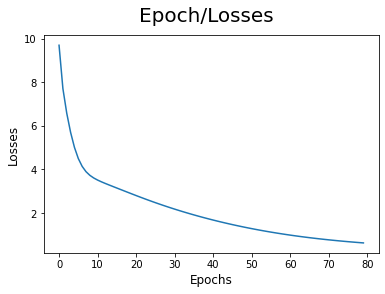

In [49]:
ix = np.arange(0,80)

fig = plt.figure()
fig.suptitle('Epoch/Losses', fontsize=20)
plt.plot(ix,[epoch_losses[i][0] for i in ix])
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Losses', fontsize=12)

Predict function

In [50]:
def predict(words):
    context_idxs = np.array([word_to_ix[w] for w in words])
    preds = forward(context_idxs, theta)
    word = ix_to_word[np.argmax(preds[-1])]
    
    return word

In [53]:
# (['we', 'are', 'to', 'study'], 'about')
predict(['is','the', 'national', 'fruit'])

'national'

Accuracy

In [54]:
def accuracy():
    wrong = 0

    for context, target in data:
        if(predict(context) != target):
            wrong += 1
            
    return (1 - (wrong / len(data)))

In [55]:
accuracy()

1.0

In [61]:
predict(['fruit', 'of', 'which', 'is'])

'india'